## Load and play

In [21]:
import pandas as pd

In [22]:
train = pd.read_csv('../../data/raw/UJIndoorLoc/trainingData.csv')
valid = pd.read_csv('../../data/raw/UJIndoorLoc/validationData.csv')

In [23]:
train.describe()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,WAP015,WAP016,WAP017,WAP018,WAP019,WAP020,WAP021,WAP022,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP037,WAP038,WAP039,WAP040,...,WAP490,WAP491,WAP492,WAP493,WAP494,WAP495,WAP496,WAP497,WAP498,WAP499,WAP500,WAP501,WAP502,WAP503,WAP504,WAP505,WAP506,WAP507,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,19937.000000,19937.000000,19937.0,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,...,19937.000000,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.0,19937.000000,1.993700e+04,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,1.993700e+04
mean,99.823644,99.820936,100.0,100.0,99.613733,97.130461,94.733661,93.820234,94.693936,99.163766,74.144606,73.899182,82.795606,82.959372,90.617144,90.627075,99.199980,99.154988,96.326529,96.577168,99.639565,99.640066,93.044239,92.999649,94.373677,94.154386,93.043136,92.785223,86.829914,86.330491,94.677685,94.687114,86.461454,86.512264,83.697196,83.694989,92.220745,93.604655,87.036565,86.731103,...,99.884386,100.0,98.956814,98.899182,99.079500,72.728545,57.995436,100.0,98.909465,98.822240,99.019812,70.857802,58.966846,83.426995,99.365953,99.981442,99.705021,99.980338,99.115313,99.943372,99.990119,84.974921,99.866881,98.881276,98.833325,99.436525,73.705673,59.889803,99.788634,99.970507,100.0,-7464.275947,4.864871e+06,1.674575,1.212820,148.429954,1.833024,9.068014,13.021869,1.371421e+09
std,5.866842,5.798156,0.0,0.0,8.615657,22.931890,30.541335,33.010404,30.305084,12.634045,62.182586,62.442166,52.005624,51.803007,40.711249,40.832376,12.301962,12.621951,25.142380,24.272157,8.359643,8.348003,34.559630,34.664154,31.181223,31.773437,34.531143,35.109838,45.940359,46.821541,30.087370,30.027574,46.513779,46.418554,50.700623,50.734245,36.648323,33.349681,45.515553,46.055288,...,4.711652,0.0,13.701929,14.211409,13.099782,63.319197,75.334826,0.0,14.020779,14.715204,13.539838,65.003736,74.736672,52.338958,10.921143,1.852874,7.476381,1.963071,12.994215,3.264807,1.395200,50.099899,5.023663,14.206023,14.634613,10.259137,62.278292,74.060259,6.360671,2.404232,0.0,123.402010,6.693318e+01,1.223078,0.833139,58.342106,0.372964,4.988720,5.362410,5.572054e+05
min,-97.000000,-90.000000,100.0,100.0,-97.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,-101.000000,-101.000000,-98.000000,-98.000000,-101.000000,-99.000000,-98.000000,-98.000000,-99.000000,-99.000000,-98.000000,-98.000000,-100.000000,-99.000000,-98.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,-99.000000,-101.000000,-98.000000,-98.000000,-100.000000,-98.000000,-99.000000,-98.000000,-100.000000,-98.000000,...,-96.000000,100.0,-90.000000,-91.000000,-97.000000,-100.000000,-101.000000,100.0,-90.000000,-91.000000,-97.000000,-101.000000,-97.000000,-102.000000,-99.000000,-85.000000,-97.000000,-97.000000,-97.000000,-98.000000,-97.000000,-103.000000,-97.000000,-92.000000,-90.000000,-97.000000,-101.000000,-101.000000,-97.000000,-97.000000,100.0,-7691.338400,4.864746e+06,0.000000,0.000000,1.00

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19937 entries, 0 to 19936
Columns: 529 entries, WAP001 to TIMESTAMP
dtypes: float64(2), int64(527)
memory usage: 80.5 MB


In [25]:
data_type = train.iloc[:,500:530].dtypes

In [26]:
train.describe

<bound method NDFrame.describe of        WAP001  WAP002  WAP003  ...  USERID  PHONEID   TIMESTAMP
0         100     100     100  ...       2       23  1371713733
1         100     100     100  ...       2       23  1371713691
2         100     100     100  ...       2       23  1371714095
3         100     100     100  ...       2       23  1371713807
4         100     100     100  ...      11       13  1369909710
...       ...     ...     ...  ...     ...      ...         ...
19932     100     100     100  ...      18       10  1371710683
19933     100     100     100  ...      18       10  1371710402
19934     100     100     100  ...      18       10  1371710921
19935     100     100     100  ...      18       10  1371711049
19936     100     100     100  ...      18       10  1371711025

[19937 rows x 529 columns]>

#### Check the if the column names train is equal than validation

In [27]:
# count the number of true statments
sum(train.columns == valid.columns)

529

In [28]:
# check if the number of columns is the same on validation than training
len(valid.columns) == len(train.columns)

True

In [29]:
# store the column names into a variable
col_names = []
for col in train.columns:
    col_names.append(col)

In [30]:
# define names for waps
wap_names = col_names[:520]

In [31]:
# filter into the dataframe
train['LONGITUDE'] > -7485.4686

0        False
1        False
2        False
3        False
4        False
         ...  
19932    False
19933     True
19934    False
19935    False
19936    False
Name: LONGITUDE, Length: 19937, dtype: bool

Steps to do: 

* Transform the data types in the right format

## Create a model to predict building

In [32]:
# subset teh waps and building
df_building = train[wap_names + ['BUILDINGID', 'LATITUDE', 'LONGITUDE']].copy()

In [33]:
df_building

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,WAP015,WAP016,WAP017,WAP018,WAP019,WAP020,WAP021,WAP022,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP037,WAP038,WAP039,WAP040,...,WAP484,WAP485,WAP486,WAP487,WAP488,WAP489,WAP490,WAP491,WAP492,WAP493,WAP494,WAP495,WAP496,WAP497,WAP498,WAP499,WAP500,WAP501,WAP502,WAP503,WAP504,WAP505,WAP506,WAP507,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,BUILDINGID,LATITUDE,LONGITUDE
0,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,1,4.864921e+06,-7541.2643
1,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,1,4.864934e+06,-7536.6212
2,100,100,100,100,100,100,100,-97,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,1,4.864950e+06,-7519.1524
3,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-92,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,1,4.864934e+06,-7524.5704
4,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,0,4.864982e+06,-7632.1436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-75,-76,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-92,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,1,4.864875e+06,-7485.4686
19933,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,-91,100,100,100,100,100,-89,-73,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,2,4.864836e+06,-7390.6206
19934,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-95,-94,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,1,4.864889e+06,-7516.8415
19935,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-91,-92,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,1,4.864896e+06,-7537.3219


In [34]:
# create a classification model
# 1. We have to be sure there is an homogenity in the data
df_building.groupby('BUILDINGID').size().reset_index(name='counts')
# we can already see we have a lot more of information on the building 2 (bias)

,BUILDINGID,counts
0,0,5249
1,1,5196
2,2,9492


In [35]:
# let's take 5200 random observations from the building 2
df_building2 = df_building[df_building['BUILDINGID'] == 2].copy()
df_building2['BUILDINGID'].describe()

count    9492.0
mean        2.0
std         0.0
min         2.0
25%         2.0
50%         2.0
75%         2.0
max         2.0
Name: BUILDINGID, dtype: float64

In [36]:
df_building2_randomSample = df_building2.sample(n=5200)

In [37]:
# extract the building 2 and add a sample into the dataframe
df_build_ready = df_building[df_building['BUILDINGID'] != 2].append(df_building2_randomSample).copy()

In [38]:
# check if now we have the same amount of observations by building
df_build_ready.groupby('BUILDINGID').size()

BUILDINGID
0    5249
1    5196
2    5200
dtype: int64

In [39]:
# now I need to change the dtype from building to categorical
df_build_ready['BUILDINGID'] = df_build_ready['BUILDINGID'].astype('category')

In [40]:
# create a train and a test in python
import numpy as np

train_id = np.random.rand(len(df_build_ready)) < 0.8
train_build = df_build_ready[train_id]
test_build = df_build_ready[~train_id]

In [41]:
# check if the samples are balanced for each building
train_build.groupby('BUILDINGID').size()

BUILDINGID
0    4170
1    4150
2    4132
dtype: int64

In [42]:
# run the the decision tree
from sklearn.tree import DecisionTreeClassifier
from random import seed

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [43]:
tree = DecisionTreeClassifier(criterion='entropy', 
                              min_samples_split=10, # if there are lesss than 20 nodes don't devide anything (by default is 2)
                              random_state=42, 
                              min_samples_leaf=5,  # minimum number of samples to create a node
                              )

In [44]:
tree.fit(X=train_build[wap_names], y=train_build['BUILDINGID'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [45]:
preds = tree.predict(test_build[wap_names])

In [46]:
# check the metrics with a confusion matrix
pd.crosstab(test_build['BUILDINGID'], preds, rownames=['Real'], colnames=['Pred'])

Pred,0,1,2
Real,,,
0,1077,2,0
1,6,1040,0
2,0,10,1058


In [47]:
print(
    "The accuracy of that model is: ", 
    sum(
        1 for x,y in zip(test_build['BUILDINGID'],preds) if x == y
    ) / len(test_build['BUILDINGID'])
)

The accuracy of that model is:  0.9943626683369872


In [48]:
# other way
from sklearn.metrics import classification_report

print(classification_report(y_true=test_build['BUILDINGID'], y_pred=preds))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1079
           1       0.99      0.99      0.99      1046
           2       1.00      0.99      1.00      1068

    accuracy                           0.99      3193
   macro avg       0.99      0.99      0.99      3193
weighted avg       0.99      0.99      0.99      3193



In [49]:
from sklearn.metrics import cohen_kappa_score

print( 
    'The kappa of that model is: ',
    cohen_kappa_score(y1 = test_build['BUILDINGID'], y2 = preds)
)

The kappa of that model is:  0.9915434094388228


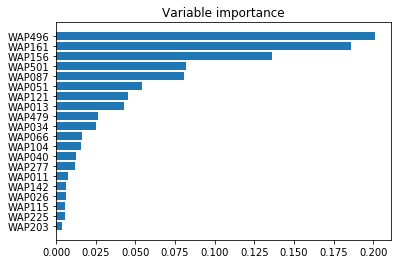

In [50]:
# find out variable importance
df_var_imp = pd.DataFrame({
    'wap_name': list(wap_names),
    'importance': list(tree.feature_importances_)    
})
data_plot = df_var_imp.sort_values(by=['importance'], ascending=True).tail(20)

import matplotlib.pyplot as plt

plt.barh(data_plot['wap_name'], data_plot['importance'])
plt.title('Variable importance')
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

In [51]:
# let's visualize the decision tree
from sklearn.tree import export_graphviz

with open('resources/building_dtree.dot', 'w') as dotfile:
    export_graphviz(tree, out_file=dotfile, feature_names=wap_names)
    dotfile.close()
    
import os # to access our files in our operative system
from graphviz import Source, Graph

file = open('resources/building_dtree.dot', 'r')
text = file.read()
text_img = Source(text)

In [52]:
# now, let's apply our model to the validation data 
val_preds = tree.predict(valid[wap_names])


In [53]:
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

def postResample_class(y_true, y_preds):
    """
    Given a vector with true results and the predictions of the model, 
    returns the confusion matrix, accuracy, kappa and a report(recall and recap) as a list. 
    """    
    # check the metrics with a confusion matrix
    confusion_matrix = pd.crosstab(y_true, y_preds, rownames=['Real'], colnames=['Pred'])
    print(confusion_matrix)
    print('')

    # print the accuracy
    accuracy = sum(1 for x,y in zip(y_preds, y_true) if x == y) / len(y_true)
    print("The accuracy of that model is: ", round(accuracy,4))

    # kappa 
    kappa = cohen_kappa_score(y1 = y_true, y2 = y_preds)
    print('The kappa of that model is: ', round(kappa,4))
    print('')

    # recall and recap
    report = classification_report(y_true=y_true, y_pred=y_preds) 
    print(report)
    
    results = [confusion_matrix, accuracy, kappa, report]
    return results


In [54]:
results = postResample_class(y_true=valid['BUILDINGID'], y_preds=val_preds)

Pred    0    1    2
Real               
0     523   13    0
1       2  304    1
2       0    6  262

The accuracy of that model is:  0.9802
The kappa of that model is:  0.9688

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       536
           1       0.94      0.99      0.97       307
           2       1.00      0.98      0.99       268

    accuracy                           0.98      1111
   macro avg       0.98      0.98      0.98      1111
weighted avg       0.98      0.98      0.98      1111



Pred    0    1    2
Real               
0     523   13    0
1       2  304    1
2       0    6  262

The accuracy of that model is:  0.9802
The kappa of that model is:  0.9688

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       536
           1       0.94      0.99      0.97       307
           2       1.00      0.98      0.99       268

    accuracy                           0.98      1111
   macro avg       0.98      0.98      0.98      1111
weighted avg       0.98      0.98      0.98      1111



/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


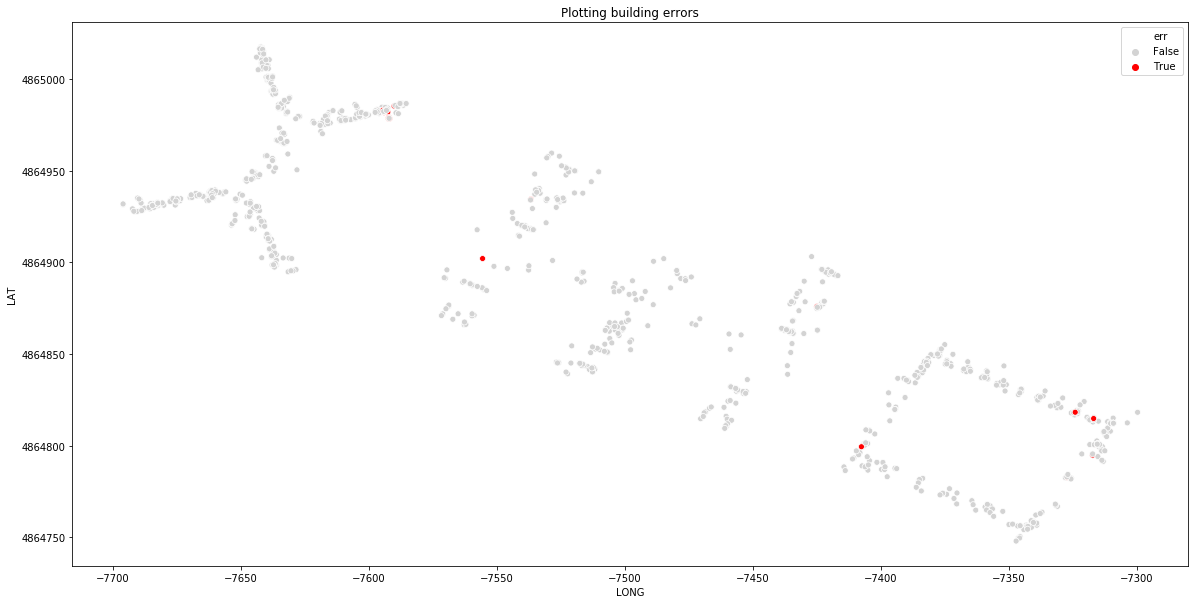

In [55]:
def plot_errors_building(df, y_true, y_pred):
    # plot the errors on the validation
    errors = y_true != y_pred
    data_plot = pd.DataFrame({
        'LONG': df['LONGITUDE'],
        'LAT': df['LATITUDE'],
        'err': errors
    })

    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.scatterplot(x='LONG', y='LAT', hue='err', data=data_plot, 
                    palette=['lightgrey','red'], x_jitter=True, y_jitter=True)
    plt.title('Plotting building errors')
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.show

preds = tree.predict(valid[wap_names])
postResample_class(valid['BUILDINGID'], preds)
plot_errors_building(valid, valid['BUILDINGID'], preds)  

In [56]:
"""
%load_ext rpy2.ipython
%%R -i R_data -w 20 -h 10 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

library(ggplot2)

data_plot = R_data[[1]]

ggplot(data_plot, aes(x=LONG, y=LAT, col=err)) +
    geom_point() +
    geom_jitter() +
    scale_color_manual(values=c("grey80","red"))+
    theme_bw()
"""

'\n%load_ext rpy2.ipython\n%%R -i R_data -w 20 -h 10 --units in -r 200\n# import df from global environment\n# make default figure size 5 by 5 inches with 200 dpi resolution\n\nlibrary(ggplot2)\n\ndata_plot = R_data[[1]]\n\nggplot(data_plot, aes(x=LONG, y=LAT, col=err)) +\n    geom_point() +\n    geom_jitter() +\n    scale_color_manual(values=c("grey80","red"))+\n    theme_bw()\n'

In [57]:
# time to try a random forest as a classification
from sklearn.ensemble import RandomForestClassifier

In [58]:
forest = RandomForestClassifier(n_jobs=2, 
                                oob_score=True, 
                                n_estimators=10, 
                                random_state=42)

In [59]:
forest.fit(X=train_build[wap_names], y=train_build['BUILDINGID'])

/home/joan/.local/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/joan/.local/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [60]:
# for each observation, random forest tell us which is the probability will fall 
# into one place or another

forest.oob_decision_function_

array([[ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [nan, nan, nan],
       ...,
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

In [61]:
# accuracy of the tree
forest.oob_score_

0.9906842274333441

In [62]:
preds = forest.predict(test_build[wap_names])

In [63]:
results = postResample_class(test_build['BUILDINGID'], preds)

Pred     0     1     2
Real                  
0     1078     1     0
1        0  1046     0
2        0     5  1063

The accuracy of that model is:  0.9981
The kappa of that model is:  0.9972

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1079
           1       0.99      1.00      1.00      1046
           2       1.00      1.00      1.00      1068

    accuracy                           1.00      3193
   macro avg       1.00      1.00      1.00      3193
weighted avg       1.00      1.00      1.00      3193



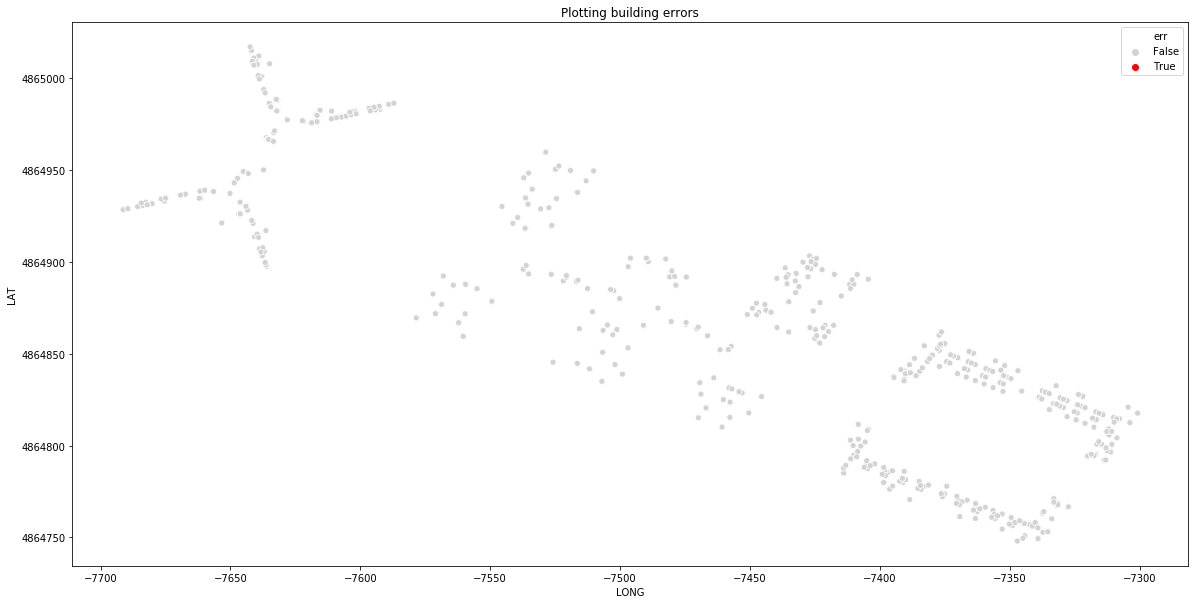

In [64]:
plot_errors_building(test_build, test_build['BUILDINGID'], preds)  

Pred    0    1    2
Real               
0     536    0    0
1       3  303    1
2       0    0  268

The accuracy of that model is:  0.9964
The kappa of that model is:  0.9943

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       536
           1       1.00      0.99      0.99       307
           2       1.00      1.00      1.00       268

    accuracy                           1.00      1111
   macro avg       1.00      1.00      1.00      1111
weighted avg       1.00      1.00      1.00      1111



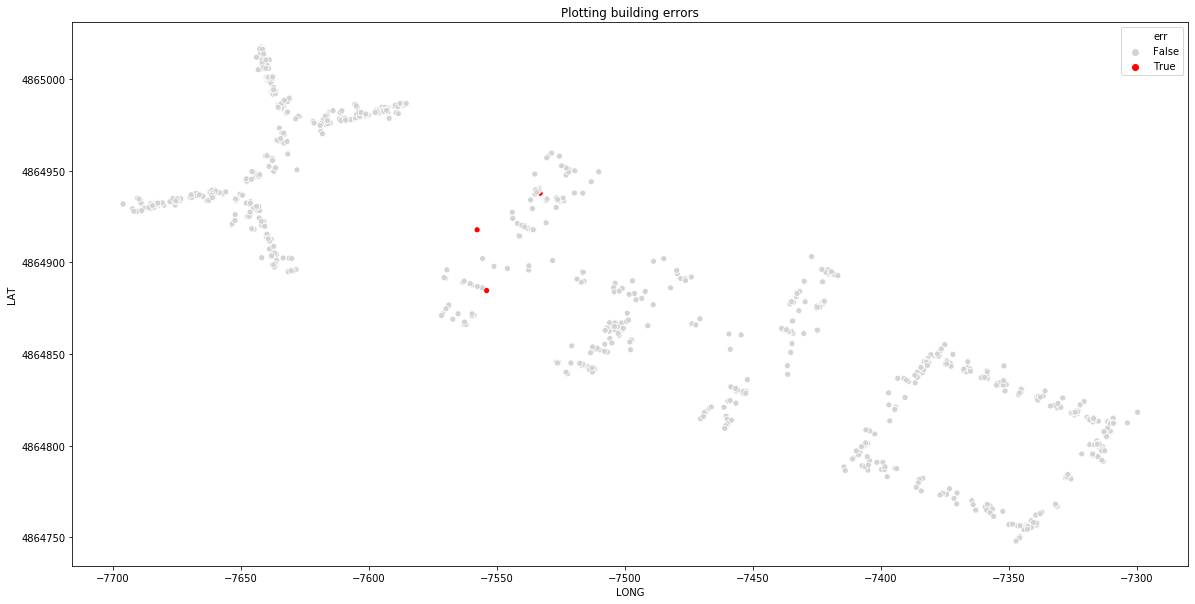

In [65]:
preds = forest.predict(valid[wap_names])
results = postResample_class(valid['BUILDINGID'], preds)
plot_errors_building(valid, valid['BUILDINGID'], preds)  

#### XGBoosting

Pred    0    1    2
Real               
0     534    2    0
1       0  307    0
2       0    0  268

The accuracy of that model is:  0.9982
The kappa of that model is:  0.9972

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       536
           1       0.99      1.00      1.00       307
           2       1.00      1.00      1.00       268

    accuracy                           1.00      1111
   macro avg       1.00      1.00      1.00      1111
weighted avg       1.00      1.00      1.00      1111



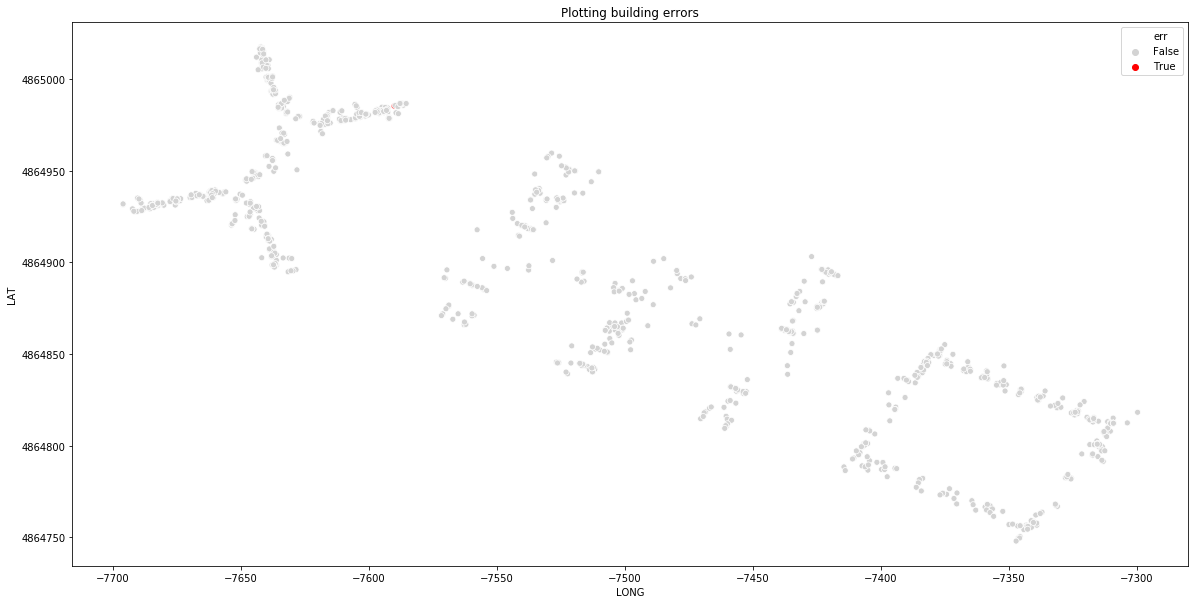

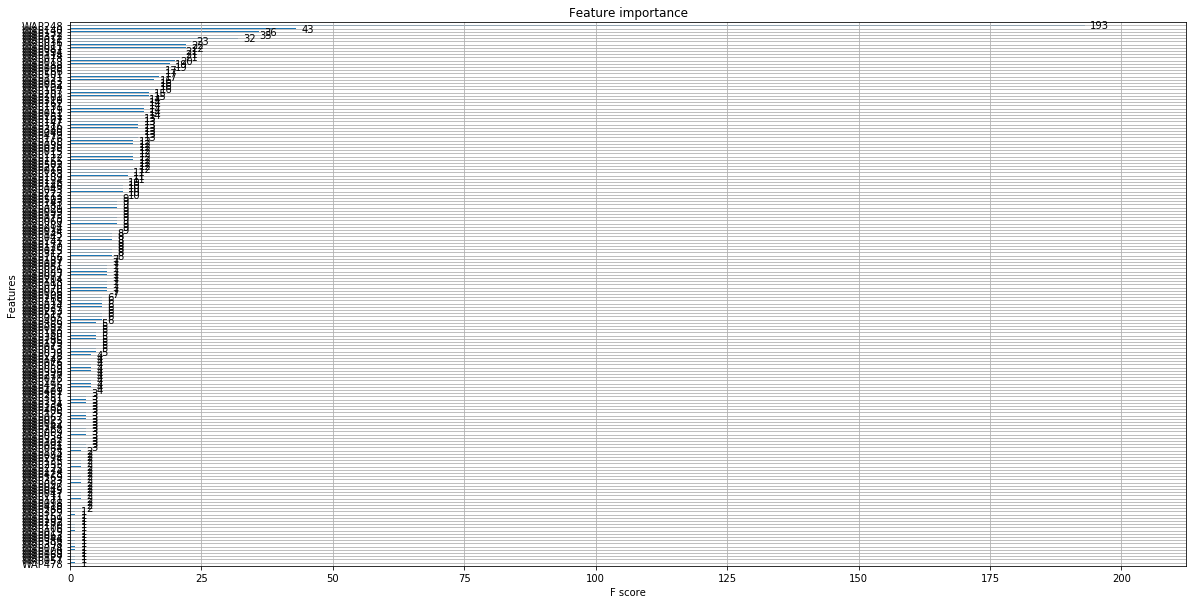

In [86]:
from xgboost import XGBClassifier
from xgboost import plot_importance
#xb_class_b = XGBClassifier()
#xb_class_b.fit(X=train_build[wap_names], y=train_build['BUILDINGID'])
preds = xb_class_b.predict(data=valid[wap_names])
results = postResample_class(y_preds=preds, y_true=valid['BUILDINGID'])
plot_errors_building(df=valid, y_true=valid['BUILDINGID'], y_pred=preds)
plot_importance(xb_class_b)

### Pre processing building

* Actions done, undersampling by random values of building 2. Why does it have the double of observations? Unique values?

In [66]:
tr_build_2 = train[train['BUILDINGID'] == 2] # 9492 observations. Do I have duplicates values?

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

In [68]:
# the floor number 3 has almos the double of the samples as the other ones
tr_build_2.drop(wap_names, axis=1).groupby('FLOOR').size()

FLOOR
0    1942
1    2162
2    1577
3    2709
4    1102
dtype: int64

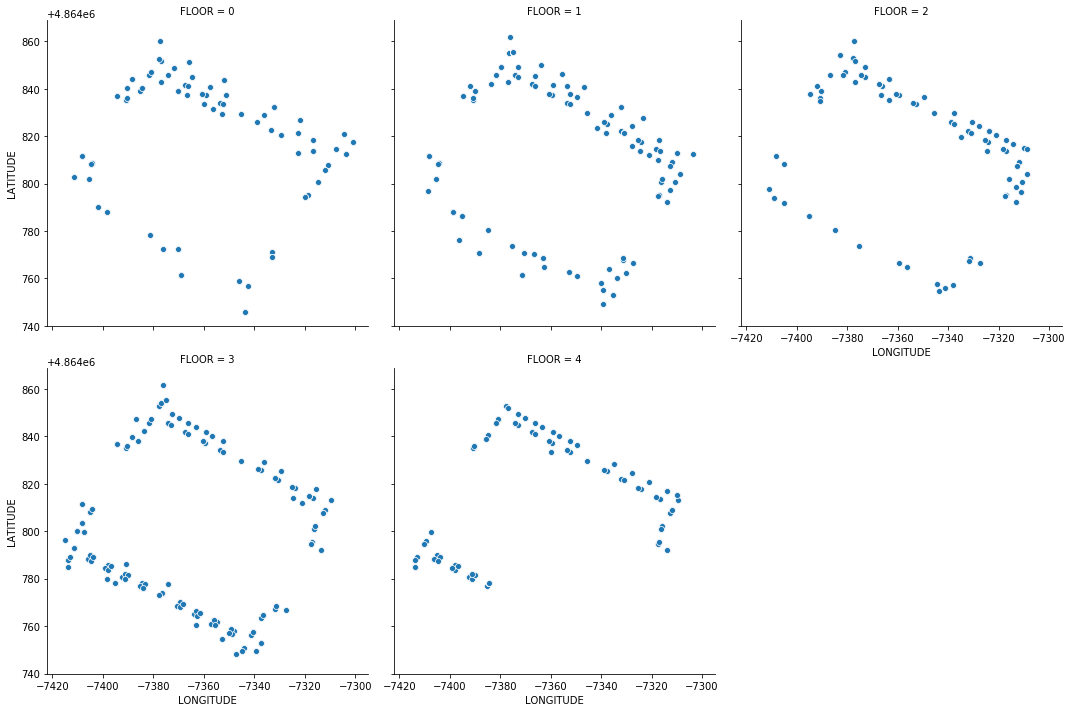

In [69]:
temp_df = tr_build_2[['LONGITUDE','LATITUDE','FLOOR']]

g = sns.FacetGrid(temp_df,col='FLOOR',col_wrap=3,aspect=1, height=5)
g.map(sns.scatterplot, 'LONGITUDE','LATITUDE')
plt.show()

Observations Building 2 by floor:

* All the floors except floor 3 has less observations on the left side. Is that going to affect our models when we use it to predict this results?
* 4rth floor has a big gap of missing values
* Floor 3 seems the floor with better colleted data. Biyt it has a lot of values collected in the same place. Maybe we can be sure we have the same amount of observations for each floor, defining the most representative observations.

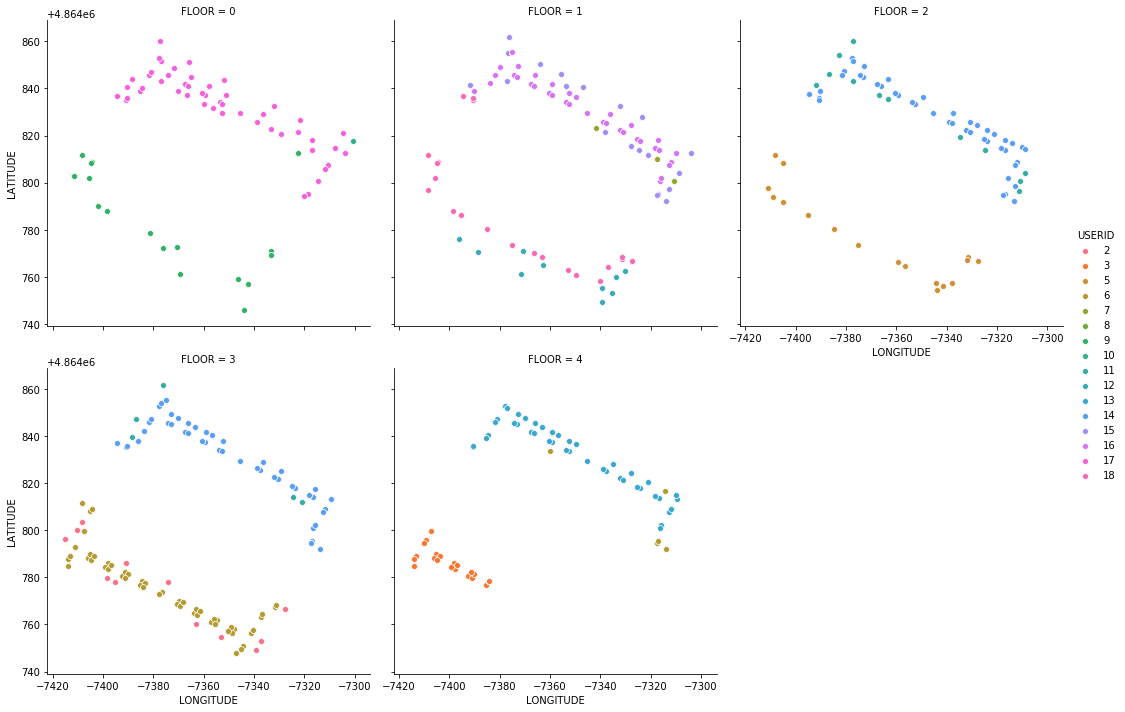

In [70]:
# Exploring the same image with user ids and phones
temp_df = tr_build_2[['LONGITUDE','LATITUDE','FLOOR','USERID']]

g = sns.FacetGrid(temp_df,col='FLOOR', hue='USERID',col_wrap=3,aspect=1, height=5)
g.map(sns.scatterplot, 'LONGITUDE','LATITUDE', edgecolor='w').add_legend()
plt.show()

The predictions for building are okey for that building. But it has a strange behaviour in relation to the data collection. 

## FLOOR prediction

#### Model for all the buildings

In [137]:
# create the datasets
count = train.groupby(['BUILDINGID','FLOOR']).size()
print(count)
#perc=count/count.groupby(level=0).sum()
#print(count, perc, sep='\n')

BUILDINGID  FLOOR
0           0        1059
            1        1356
            2        1443
            3        1391
1           0        1368
            1        1484
            2        1396
            3         948
2           0        1942
            1        2162
            2        1577
            3        2709
            4        1102
dtype: int64


In [144]:
from sklearn.model_selection import train_test_split 

In [150]:
X_train, X_test, y_train, y_test=train_test_split(train[wap_names],
                                                  train['FLOOR'],
                                                  train_size=0.8, random_state=42)

In [156]:
tree_all_floor = DecisionTreeClassifier(
    criterion='entropy', 
    min_samples_split=10, # if there are lesss than 20 nodes don't devide anything (by default is 2)
    random_state=42, 
    min_samples_leaf=5,  # minimum number of samples to create a node
    )

In [158]:
tree_all_floor.fit(X=X_train[wap_names], y=y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [160]:
preds=tree_all_floor.predict(X_test)

results = postResample_class(y_preds=preds, y_true=y_test)

Pred    0    1    2    3    4
Real                         
0     848   23    4   11    0
1      30  944   22   14    0
2       3   33  818   28    0
3       2    7   32  952    5
4       0    0    2    5  205

The accuracy of that model is:  0.9446
The kappa of that model is:  0.9282

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       886
           1       0.94      0.93      0.94      1010
           2       0.93      0.93      0.93       882
           3       0.94      0.95      0.95       998
           4       0.98      0.97      0.97       212

    accuracy                           0.94      3988
   macro avg       0.95      0.95      0.95      3988
weighted avg       0.94      0.94      0.94      3988



In [161]:
preds=tree_all_floor.predict(valid[wap_names])

results = postResample_class(y_preds=preds, y_true=valid['FLOOR'])

Pred    0    1    2    3   4
Real                        
0     106   16    5    5   0
1      43  314   84   21   0
2       5   22  225   50   4
3       0   10   23  134   5
4       0    1    0   11  27

The accuracy of that model is:  0.7255
The kappa of that model is:  0.6251

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       132
           1       0.87      0.68      0.76       462
           2       0.67      0.74      0.70       306
           3       0.61      0.78      0.68       172
           4       0.75      0.69      0.72        39

    accuracy                           0.73      1111
   macro avg       0.72      0.74      0.72      1111
weighted avg       0.75      0.73      0.73      1111



Pred    0    1    2    3   4
Real                        
0     106   16    5    5   0
1      43  314   84   21   0
2       5   22  225   50   4
3       0   10   23  134   5
4       0    1    0   11  27

The accuracy of that model is:  0.7255
The kappa of that model is:  0.6251

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       132
           1       0.87      0.68      0.76       462
           2       0.67      0.74      0.70       306
           3       0.61      0.78      0.68       172
           4       0.75      0.69      0.72        39

    accuracy                           0.73      1111
   macro avg       0.72      0.74      0.72      1111
weighted avg       0.75      0.73      0.73      1111



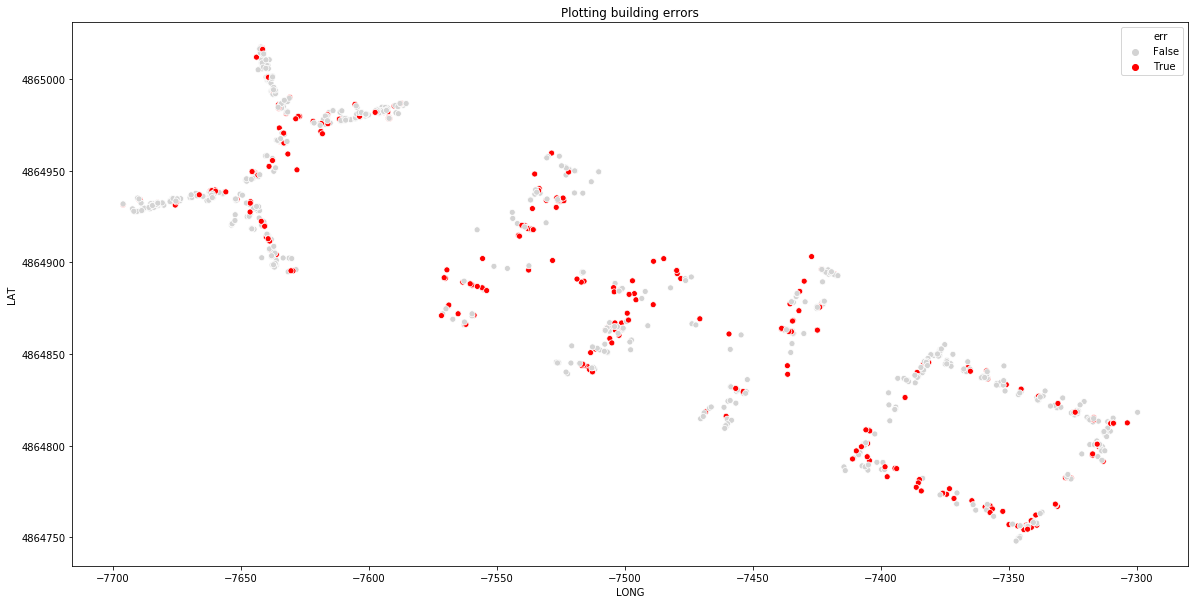

In [163]:
preds = tree_all_floor.predict(valid[wap_names])

results = postResample_class(y_preds=preds, y_true=valid['FLOOR'])

plot_errors_building(df=valid, y_pred=preds, y_true=valid['FLOOR'])

In [166]:
from xgboost import XGBClassifier

xb_class = XGBClassifier()

In [167]:
xb_class.fit(X=train[wap_names], y=train['FLOOR'])

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

Pred    0    1    2    3   4
Real                        
0     118    6    6    2   0
1      30  382   46    4   0
2       1    9  278   18   0
3       0    2    4  163   3
4       0    1    0   14  24

The accuracy of that model is:  0.8686
The kappa of that model is:  0.8182

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       132
           1       0.95      0.83      0.89       462
           2       0.83      0.91      0.87       306
           3       0.81      0.95      0.87       172
           4       0.89      0.62      0.73        39

    accuracy                           0.87      1111
   macro avg       0.86      0.84      0.84      1111
weighted avg       0.88      0.87      0.87      1111



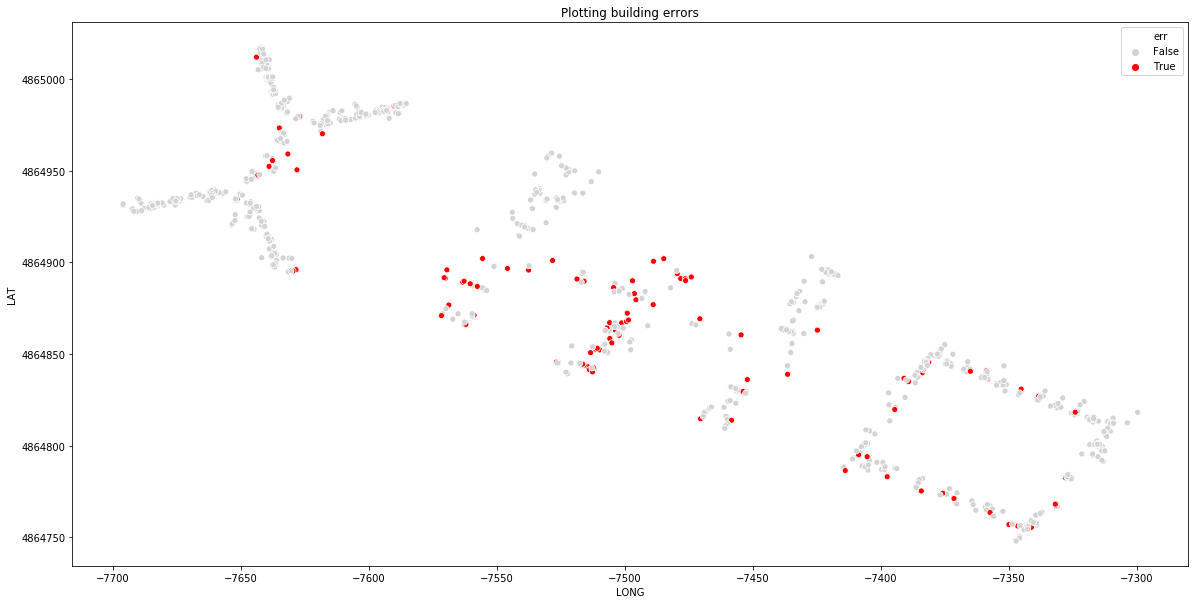

In [168]:
preds = xb_class.predict(data=valid[wap_names])
results = postResample_class(y_preds=preds, y_true=valid['FLOOR'])
plot_errors_building(df=valid, y_true=valid['FLOOR'], y_pred=preds)

### How can we predict by floor 

We can try to create models by Building

In [217]:
df_build=[]
valid_build=[]

for building in range(3):
    train_building = train[train['BUILDINGID']==building]
    valid_building = valid[valid['BUILDINGID']==building]
    df_build.append(train_building)
    valid_build.append(valid_building)

In [ ]:
def floor_predictions(train, valid, wap_names, model_fct):
    """
    Given the train and validation data, create a model and return the metrics of 
    that model. 
    """
    # create train and test
    temp_train, temp_test = train_test_split(
        floor_train, train_size=0.8, random_state=42
    )
    
    # create the mdoel
    model_trained = model_fct.fit(temp_train[wap_names], temp_train['FLOOR'])
    
    # check the metrics in testing
    print("The metrics for the test: ", sep="\n")
    test_preds = model_trained.predict(temp_test[wap_names])
    results_test = postResample_class(y_preds=test_preds, y_true=temp_test['FLOOR'])
    
    # check the metrics in validation
    print("The metrics for the validation: ", sep="\n")
    valid_preds = model_trained.predict(valid[wap_names])
    results_validation = postResample_class(y_preds=valid_preds, y_true=valid['FLOOR'])
    
    # return the results on validation
    return results_validation

In [260]:
# BUILDING ID
building_number = int(input('Select the building: '))
floor_train = df_build[building_number]
floor_valid = valid_build[building_number]

Select the building:  2


In [261]:
# create the model
tree = XGBClassifier()

# run the function
output = floor_predictions(
    train=floor_train, valid=floor_valid, wap_names=wap_names, model_fct=tree
)

The metrics for the test: 
Pred    0    1    2    3    4
Real                         
0     373    0    0    0    0
1       2  431    0    0    0
2       1    0  311    0    0
3       0    0    0  558    0
4       0    0    0    0  223

The accuracy of that model is:  0.9984
The kappa of that model is:  0.998

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       373
           1       1.00      1.00      1.00       433
           2       1.00      1.00      1.00       312
           3       1.00      1.00      1.00       558
           4       1.00      1.00      1.00       223

    accuracy                           1.00      1899
   macro avg       1.00      1.00      1.00      1899
weighted avg       1.00      1.00      1.00      1899

The metrics for the validation: 
Pred   0    1   2   3   4
Real                     
0     21    3   0   0   0
1      2  107   2   0   0
2      0    5  42   7   0
3      0    0   0  39   1
4      2 

In [ ]:
# create the model
tree = RandomForestClassifier()

# run the function
output = floor_predictions(
    train=floor_train, valid=floor_valid, wap_names=wap_names, model_fct=tree
)

In [211]:
floor_train.groupby('FLOOR').size()

FLOOR
0     848
1    1090
2    1152
3    1109
dtype: int64